In [113]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# train test split
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchinfo import summary
import segmentation_models_pytorch as smp
from torchvision import transforms

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

In [114]:
# Total Images
IMAGE_PATH = Path("./images")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*.png"))
IMAGE_PATH_LIST = sorted(IMAGE_PATH_LIST)

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 31


In [115]:
# Total Masks
MASK_PATH = Path("./masks")
MASK_PATH_LIST = list(MASK_PATH.glob("*.png"))
MASK_PATH_LIST = sorted(MASK_PATH_LIST)

print(f'Total Masks = {len(MASK_PATH_LIST)}')

Total Masks = 31


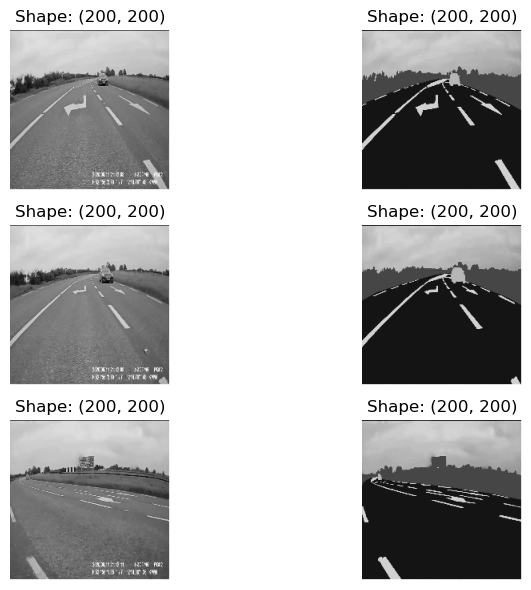

In [117]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9, 6))

for i, (img_path, mk_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    if i > 2:
        break

    img_gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img_gray, (200, 200))
    ax[i, 0].imshow(img_resized, cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Shape: {img_resized.shape}')

    mask_gray = cv2.imread(str(mk_path), cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask_gray, (200, 200))
    ax[i, 1].imshow(mask_resized, cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title(f'Shape: {mask_resized.shape}')

fig.tight_layout()
plt.show()

In [118]:
images_paths = [None] * len(IMAGE_PATH_LIST)
masks_paths = [None] * len(MASK_PATH_LIST)

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    images_paths[i] = img_path
    masks_paths[i] = mask_path

data = pd.DataFrame({'Image':images_paths, 'Mask':masks_paths})
data.head()

,Image,Mask
0,images\0.png,masks\0.png
1,images\1.png,masks\1.png
2,images\10.png,masks\10.png
3,images\11.png,masks\11.png
4,images\12.png,masks\12.png


In [6]:
data_train, data_rest = train_test_split(data,test_size = 0.3)

data_val, data_test = train_test_split(data_rest,test_size = 0.5)

In [7]:
# We create a **dictionary** where we have stored the **color** and its respective **id** of each class.

color2id = {(184, 61, 245): 0, # #b83df5: backgroud
            (255, 53, 94):1, # #ff355e: road_sign
            (255, 204, 51):2, # #ffcc33: car
            (221, 255, 51):3, # #ddff33: marking
            (61,61, 245):4} # #3d3df5: road_surface

In [8]:
def mapping_color(img:Image, color2id:dict):

    image = np.array(img)

    height,width,_ = image.shape
    output_matrix = np.full(shape = (height, width), fill_value = -1, dtype = np.int32)

    for h in range(height):
        for w in range(width):
            color_pixel = tuple(image[h,w,:])

            if color_pixel in color2id:
                output_matrix[h,w] = color2id[color_pixel]


    return output_matrix

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data:pd.DataFrame, color2id:dict, image_transforms, mask_transforms):
        self.data = data
        self.color2id = color2id
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_path = data.iloc[idx, 0]
        image = Image.open(image_path).convert("L")
        image = self.image_transforms(image)

        mask_path = data.iloc[idx, 1]
        mask = Image.open(mask_path).convert("RGB")
        mask = self.mask_transforms(mask)
        mask = mapping_color(mask, self.color2id)

        return image, mask

In [10]:
RESIZE = (128, 128)

image_transforms = transforms.Compose([transforms.Resize(RESIZE),
                                       transforms.ToTensor()])

mask_transforms = transforms.Compose([transforms.Resize(RESIZE)])

In [11]:
train_dataset = CustomDataset(data_train,
                              color2id,
                              image_transforms,
                              mask_transforms)

val_dataset = CustomDataset(data_val,
                            color2id,
                            image_transforms,
                            mask_transforms)

In [12]:
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = 1,
                            shuffle = True)

In [13]:
batch_images, batch_masks = next(iter(train_dataloader))

batch_images.shape, batch_masks.shape

(torch.Size([1, 1, 128, 128]), torch.Size([1, 128, 128]))

In [14]:
model = smp.Unet(classes=5,in_channels=1)
summary(model=model,
        col_width=17,
        input_size=[1, 1, 128, 128],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 1, 128, 128]  [1, 5, 128, 128]  --                True
├─ResNetEncoder (encoder)                          [1, 1, 128, 128]  [1, 1, 128, 128]  --                True
│    └─Conv2d (conv1)                              [1, 1, 128, 128]  [1, 64, 64, 64]   3,136             True
│    └─BatchNorm2d (bn1)                           [1, 64, 64, 64]   [1, 64, 64, 64]   128               True
│    └─ReLU (relu)                                 [1, 64, 64, 64]   [1, 64, 64, 64]   --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 64, 64]   [1, 64, 32, 32]   --                --
│    └─Sequential (layer1)                         [1, 64, 32, 32]   [1, 64, 32, 32]   --                True
│    │    └─BasicBlock (0)                         [1, 64, 32, 32]   [1, 64, 32, 32]   73,984            True
│    │   

In [15]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [16]:
model = smp.Unet(classes=5,in_channels=1)
summary(model=model,
        col_width=17,
        input_size=[1, 1, 128, 128],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 1, 128, 128]  [1, 5, 128, 128]  --                True
├─ResNetEncoder (encoder)                          [1, 1, 128, 128]  [1, 1, 128, 128]  --                True
│    └─Conv2d (conv1)                              [1, 1, 128, 128]  [1, 64, 64, 64]   3,136             True
│    └─BatchNorm2d (bn1)                           [1, 64, 64, 64]   [1, 64, 64, 64]   128               True
│    └─ReLU (relu)                                 [1, 64, 64, 64]   [1, 64, 64, 64]   --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 64, 64]   [1, 64, 32, 32]   --                --
│    └─Sequential (layer1)                         [1, 64, 32, 32]   [1, 64, 32, 32]   --                True
│    │    └─BasicBlock (0)                         [1, 64, 32, 32]   [1, 64, 32, 32]   73,984            True
│    │   

In [64]:
class_weights = torch.tensor([1,1,1,5,1])
def weighted_dice_loss(y_true, y_pred):
    dice_loss = smp.losses.DiceLoss(mode="multiclass", classes=5, ignore_index=-1)(y_true, y_pred)
    weighted_loss = torch.mean(dice_loss * class_weights)
    return weighted_loss

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

In [41]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)

        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
early_stopping = EarlyStopping(patience = 20, delta = 0.)

In [42]:
DEVICE = 'cpu'
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader,
               loss_fn:smp.losses, optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    train_iou = 0.

    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)

        optimizer.zero_grad()

        pred_logit = model(X)
        loss = loss_fn(pred_logit, y)
        train_loss = loss.item()

        loss.backward()
        optimizer.step()

        pred_prob = pred_logit.softmax(dim = 1)
        pred_class = pred_prob.argmax(dim = 1)

        tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(),
                                            target = y.cpu(),
                                            mode = "multiclass",
                                            ignore_index = -1,
                                            num_classes = 5)

        train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")

    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)

    return train_loss, train_iou

In [43]:
def val_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader,
             loss_fn:smp.losses):

    model.eval()

    val_loss = 0.
    val_iou = 0.

    with torch.inference_mode():

        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)

            pred_logit = model(X)
            loss = loss_fn(pred_logit, y)
            val_loss = loss.item()

            pred_prob = pred_logit.softmax(dim = 1)
            pred_class = pred_prob.argmax(dim = 1)

            tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(),
                                                target = y.cpu(),
                                                mode = "multiclass",
                                                ignore_index = -1,
                                                num_classes = 5)

            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")


    val_loss = val_loss / len(dataloader)
    val_iou = val_iou / len(dataloader)

    return val_loss, val_iou

In [44]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader,
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, early_stopping, epochs:int = 10):

    results = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        val_loss, val_iou = val_step(model = model,
                                     dataloader = val_dataloader,
                                     loss_fn = loss_fn)

        print(f'Epoch: {epoch + 1} | ',
              f'Train Loss: {train_loss:.4f} | ',
              f'Train IOU: {train_iou:.4f} | ',
              f'Val Loss: {val_loss:.4f} | ',
              f'Val IOU: {val_iou:.4f}')

        early_stopping(val_loss, model)

        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break

        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)

    return results

In [65]:
# Training!!!
EPOCHS = 10

torch.cuda.manual_seed(14)
torch.manual_seed(14)


RESULTS = train(model.to(device=DEVICE),
                train_dataloader,
                val_dataloader,
                weighted_dice_loss,
                optimizer,
                early_stopping,
                EPOCHS)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.0194 |  Train IOU: 0.9139 |  Val Loss: 0.1836 |  Val IOU: 0.8968
Epoch: 2 |  Train Loss: 0.0336 |  Train IOU: 0.9388 |  Val Loss: 0.1722 |  Val IOU: 0.7435
Epoch: 3 |  Train Loss: 0.0137 |  Train IOU: 0.9222 |  Val Loss: 0.1961 |  Val IOU: 0.8106
Epoch: 4 |  Train Loss: 0.0342 |  Train IOU: 0.9355 |  Val Loss: 0.1613 |  Val IOU: 0.9621
Epoch: 5 |  Train Loss: 0.0180 |  Train IOU: 0.9480 |  Val Loss: 0.1616 |  Val IOU: 0.9497
Epoch: 6 |  Train Loss: 0.0368 |  Train IOU: 0.9460 |  Val Loss: 0.1616 |  Val IOU: 0.9755
Epoch: 7 |  Train Loss: 0.0382 |  Train IOU: 0.9405 |  Val Loss: 0.0587 |  Val IOU: 0.8124
Early Stopping!!


In [82]:
import segmentation_models_pytorch as smp

def predictions(test_dataloader: torch.utils.data.DataLoader, best_model: str):
    checkpoint = torch.load(best_model)

    loaded_model = smp.Unet(encoder_name="resnet34", encoder_weights=None, classes=5, in_channels=1)

    loaded_model.load_state_dict(checkpoint)
    loaded_model.to(device=DEVICE)
    loaded_model.eval()

    pred_mask_test = []

    with torch.no_grad():
        for X, _ in tqdm(test_dataloader):
            X = X.to(device=DEVICE, dtype=torch.float32)
            logit_mask = loaded_model(X)
            prob_mask = logit_mask.softmax(dim=1)
            pred_mask = prob_mask.argmax(dim=1)
            pred_mask_test.append(pred_mask.cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test


In [83]:
test_dataset = CustomDataset(data_test, color2id, image_transforms, mask_transforms)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [84]:
pred_mask_test = predictions(test_dataloader, "./best_model.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

In [85]:
# We are going to create our tensors so we can plot later.
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_dataloader:
    IMAGE_TEST.append(img)
    MASK_TEST.append(mask)

IMAGE_TEST = torch.cat(IMAGE_TEST)

MASK_TEST = torch.cat(MASK_TEST)

In [86]:
TP, FP, FN, TN = smp.metrics.get_stats(output = pred_mask_test.long(),
                                       target = MASK_TEST.long(),
                                       mode = "multiclass",
                                       ignore_index = -1,
                                       num_classes = 5)

In [87]:
iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

IOU Test = 0.8051


In [88]:
id2color = {0: (184, 61, 245), # background
            1: (255, 53, 94), # road_sign
            2: (255, 204, 51), # car
            3: (221, 255, 51), # marking
            4: (61,61, 245)} # road_surface

In [89]:
total_mask_output = []

for i,mask_pred in enumerate(pred_mask_test):

    # We extract the height and width of the mask.
    height,width = mask_pred.shape

    # We are going to create a Boolean array to filter the values -1, which is that id that does not belong to any class.
    mask_original = MASK_TEST[i]
    ignore = mask_original == -1 # id: -1

    mask_predicted = torch.where(ignore, -1, mask_pred)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)

    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h,w])

            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])

    total_mask_output.append(mask_zeros)

In [90]:
total_mask_test = []

for mask_tst in MASK_TEST:

    # Extraemos el height y width de la máscara.
    height,width = mask_tst.shape

    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)

    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h,w])

            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])

    total_mask_test.append(mask_zeros)

C:\Users\micha\AppData\Local\Temp\ipykernel_12680\2559998844.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


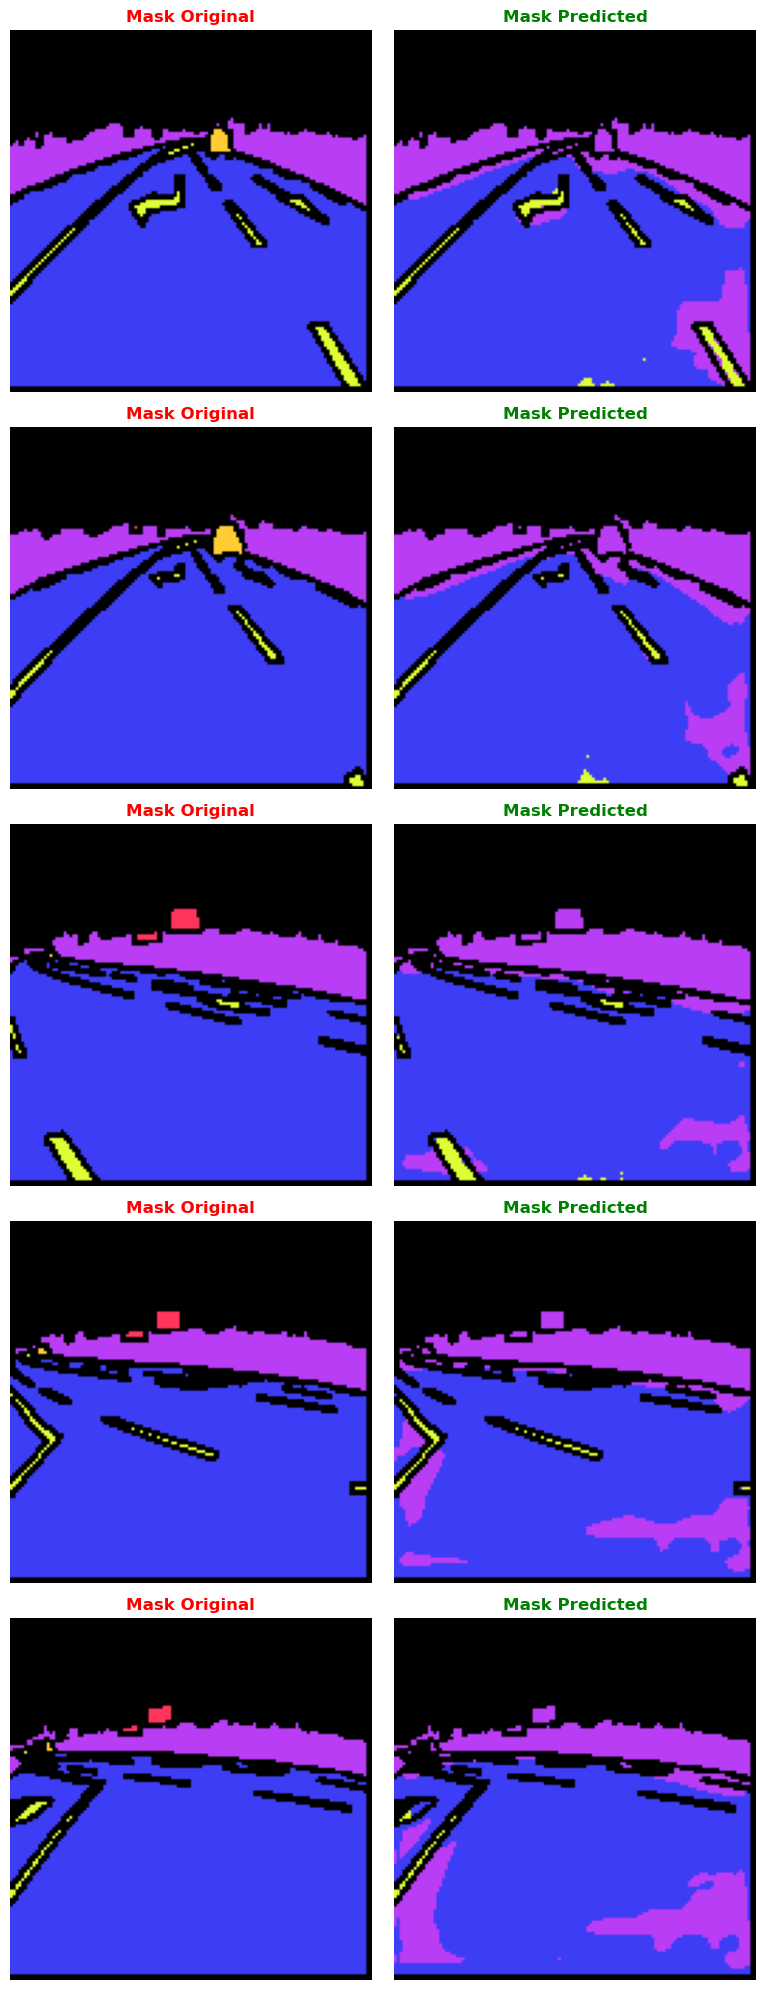

In [91]:
# Finally, we visualize the predicted mask and the actual mask.
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (8,20))

for i,(mk_out,mk_test) in enumerate(zip(total_mask_output, total_mask_test)):

    mask_test = mk_test.numpy()
    ax[i,0].imshow(mask_test)
    ax[i,0].set_title("Mask Original", fontsize = 12, fontweight = "bold", color = "red")
    ax[i,0].axis('off')

    mask_out = mk_out.numpy()
    ax[i,1].imshow(mask_out)
    ax[i,1].set_title("Mask Predicted", fontsize = 12, fontweight = "bold", color = "green")
    ax[i,1].axis('off')

fig.tight_layout()
fig.show()